# Data Preprocessing

Data visualization, preprocessing, and normalization

In [1]:
import os
import numpy as np
import pandas as pd
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import ipywidgets as widgets
from IPython.display import display, clear_output

%matplotlib widget

## Resample the data and derive velocity and acceleration

The fpv-uzh and mid-air datasets have different sample rates and formats. This code is meant to resample everything to 10hz (sample time = 0.1sec). It does this via block means as a simple noise reduction method. More sophisticated noise reduction techniques need to be explored later.

The sample rate is can actually be thought of as a hyperparameter for our model. For now, we are following the VECTOR GRU paper.

The model can either be trained on positional, velocity, or acceleration data.

At the moment, the acceleration data seems to be too noisy to be useful.

In [ ]:
def resample(df: pd.DataFrame, sampling_time: float):
    """
    This function takes the block average as a simple way to reduce noise
    """
    df = df.sort_values("timestamp")
    bins = np.arange(
        df['timestamp'].min(), 
        df['timestamp'].max() + sampling_time + 1e-9, 
        sampling_time
    )
    
    df["bin_index"] = np.digitize(df["timestamp"], bins, right=True)

    grouped = df.groupby("bin_index")
    mean_values = grouped[["tx", "ty", "tz"]].mean()

    unique_grouped_indices = mean_values.index.values

    valid_indices_mask = unique_grouped_indices > 0
    
    filtered_bin_indices = unique_grouped_indices[valid_indices_mask]
    filtered_mean_values = mean_values[valid_indices_mask]

    df_resampled = pd.DataFrame({
        # For a bin_index 'k', the block starts at bins[k-1]
        'timestamp': bins[filtered_bin_indices - 1],
        'tx': filtered_mean_values["tx"].values,
        'ty': filtered_mean_values["ty"].values,
        'tz': filtered_mean_values["tz"].values
    })
    
    return df_resampled

def velocity(df: pd.DataFrame):
    out = pd.DataFrame(columns=["timestamp", "vx", "vy", "vz"])
    dt = df["timestamp"].diff()

    out["timestamp"] = df["timestamp"]
    out["vx"] = df["tx"].diff() / dt
    out["vy"] = df["ty"].diff() / dt
    out["vz"] = df["tz"].diff() / dt

    return out.iloc[1:]

def acceleration(df: pd.DataFrame):
    out = pd.DataFrame(columns=["timestamp", "ax", "ay", "az"])
    dt = df["timestamp"].diff()

    out["timestamp"] = df["timestamp"]
    out["ax"] = df["vx"].diff() / dt
    out["ay"] = df["vy"].diff() / dt
    out["az"] = df["vz"].diff() / dt

    return out.iloc[1:]

# resample everything in "data/clean" and save positional and velocity data.
out_path_pos = "data/position/raw"
out_path_vel = "data/velocity/raw"
out_path_acc = "data/acceleration/raw"
os.makedirs(out_path_pos, exist_ok=True)
os.makedirs(out_path_vel, exist_ok=True)
os.makedirs(out_path_acc, exist_ok=True)

def walk_and_process(root):
    for dirname in os.listdir(root):
        os.makedirs(os.path.join(out_path_pos, dirname), exist_ok=True)
        os.makedirs(os.path.join(out_path_vel, dirname), exist_ok=True)
        os.makedirs(os.path.join(out_path_acc, dirname), exist_ok=True)
        for filename in os.listdir(os.path.join(root, dirname)):
            df = pd.read_csv(os.path.join(root, dirname, filename))
            pos = resample(df, 0.1)
            vel = velocity(pos)
            acc = acceleration(vel)
            pos.to_csv(os.path.join(out_path_pos, dirname, filename))
            vel.to_csv(os.path.join(out_path_vel, dirname, filename))
            acc.to_csv(os.path.join(out_path_acc, dirname, filename))
    
 
walk_and_process(root="data/clean")

## Data Normalization

Computes the global L2 norm and normalizes data against it.

In [32]:
def scale_by(df: pd.DataFrame, x: str, y: str, z: str, max):
    df[x] = df[x] / max
    df[y] = df[y] / max
    df[z] = df[z] / max

def max_mag(df: pd.DataFrame, x: str, y: str, z: str):
    return np.max(np.sqrt(df[x]**2 + df[y]**2 + df[z]**2))    


def walk_and_normalize(root="data/velocity/raw", out = "data/velocity/max_norm"):
    os.makedirs(out, exist_ok=True)

    max = 0
    for dirname in os.listdir(root):
        for filename in os.listdir(os.path.join(root, dirname)):
            curr = max_mag(
                pd.read_csv(
                    os.path.join(root, dirname, filename), 
                    usecols=["timestamp", "vx", "vy", "vz"]
                    ), 
                "vx", "vy", "vz"
            )

            max = curr if curr > max else max
    
    for dirname in os.listdir(root):
        os.makedirs(os.path.join(out, dirname))
        for filename in os.listdir(os.path.join(root, dirname)):
            df = pd.read_csv(
                os.path.join(root, dirname, filename), 
                usecols=["timestamp", "vx", "vy", "vz"]
            )
            scale_by(df, "vx", "vy", "vz", max)
            df.to_csv(os.path.join(out, dirname, filename))


walk_and_normalize()

# K-fold Cross validation

Code to generate 5 folds with training, testing, and validation sets and saves as json file.

This way we have "global access" to the folds, and the jobs we queue can independently work on a fold.

In [2]:
from src.datasets import Fold, generate_folds, save_folds

root="data/velocity/max_norm"
strata = os.listdir(root)
folds: list[Fold] = generate_folds(
    root=root, 
    strata=strata, 
    k = 5, 
    shuffle = False
)

output_file = "data/folds.json"
save_folds(folds, output_file)

## Interactive path visualization

This code assumes you have `position`, `velocity`, and `acceleration` directories, and that the columns are formatted correctly.

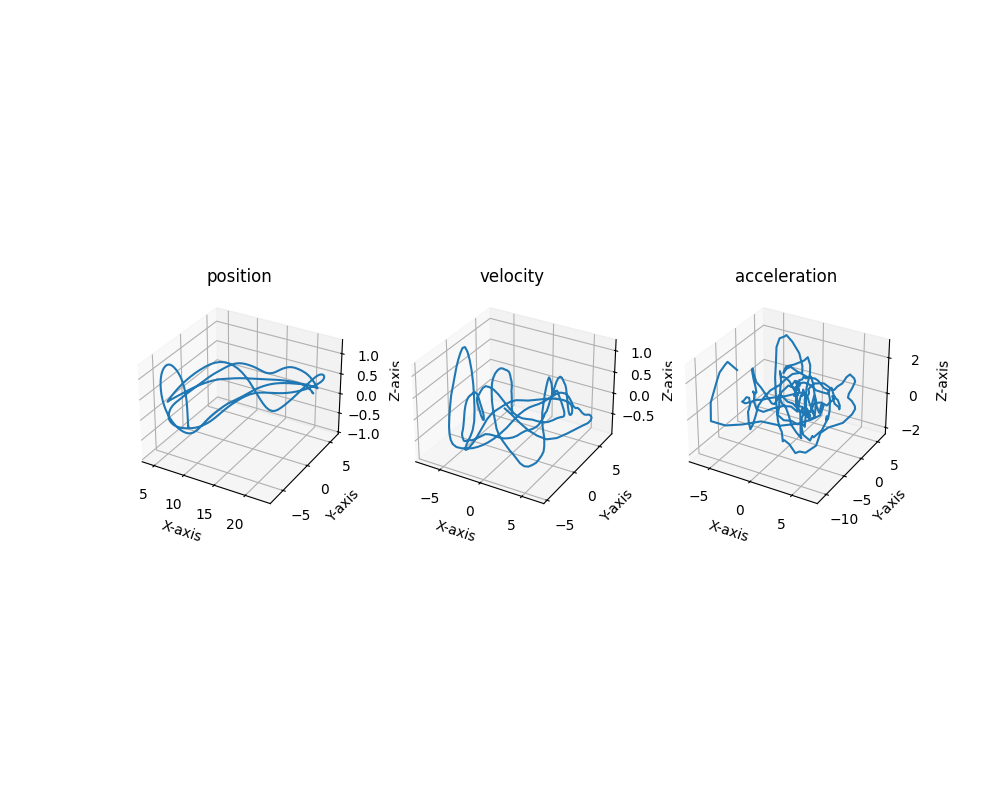

In [3]:
coords = {
    "position": ["tx", "ty", "tz"],
    "velocity": ["vx", "vy", "vz"],
    "acceleration": ["ax", "ay", "az"],
}

coord_types = list(coords.keys())

def create_interactive_3d_plot(norm="raw"):
    root = "./data"
    # Just start out with position
    dirs = os.listdir(os.path.join(root, coord_types[0], norm))

    directory_dropdown = widgets.Dropdown(
        options=dirs,
        description="Select Directory:",
        disabled=False
    )

    # Get a list of all CSV files in the specified directory
    csv_files = os.listdir(os.path.join(root, coord_types[0], norm, dirs[0]))
    if not csv_files:
        print(f"No CSV files found in {os.path.abspath(root)}")
        return

    # Create a dropdown widget for file selection
    file_dropdown = widgets.Dropdown(
        options=csv_files,
        description="Select CSV:",
        disabled=False,
    )

    output_area = widgets.Output()

    fig = plt.figure(figsize=(10, 8))
    axs = {
        "position": fig.add_subplot(131, projection="3d"),
        "velocity": fig.add_subplot(132, projection="3d"),
        "acceleration": fig.add_subplot(133, projection="3d"),
    }

    def update_files(change):
        with output_area:
            clear_output(wait=True)
            selected_directory = change["new"]
            new_files = os.listdir(os.path.join(root, coord_types[0], norm, selected_directory))

            if new_files:
                file_dropdown.options = new_files
                file_dropdown.disabled = False
            else:
                file_dropdown.options = ["No files"]
                file_dropdown.disabled = True

    def update_plot(change):
        with output_area:
            clear_output(wait=True)
            selected_file = change["new"]
            selected_directory = directory_dropdown.value
            
            for c in coord_types:
                file_path = os.path.join(root, c, norm, selected_directory, selected_file)
                ax = axs[c]
                ax.clear()
                
                try:
                    df = pd.read_csv(file_path)
                    x, y, z = coords [c]
                    if x not in df.columns or y not in df.columns or z not in df.columns:
                        ax.clear() # Clear any previous plot or error message
                        ax.text2D(0.5, 0.5, f"Error: '{file_path}' missing '{x}', '{y}', or '{z}' columns.", # type: ignore
                                transform=ax.transAxes, ha="center")
                        fig.canvas.draw_idle()
                        return

                    ax.clear()

                    line = ax.plot(df[x], df[y], df[z])[0]

                    # Update labels and title
                    ax.set_xlabel("X-axis")
                    ax.set_ylabel("Y-axis")
                    ax.set_zlabel("Z-axis")
                    ax.set_title(c)

                    # Ensure data limits are set correctly for the new data
                    x_min, x_max = df[x].min(), df[x].max()
                    y_min, y_max = df[y].min(), df[y].max()
                    z_min, z_max = df[z].min(), df[z].max()

                    # Add a small buffer to the limits for better visualization
                    x_buffer = (x_max - x_min) * 0.05
                    y_buffer = (y_max - y_min) * 0.05
                    z_buffer = (z_max - z_min) * 0.05

                    ax.set_xlim(x_min - x_buffer, x_max + x_buffer)
                    ax.set_ylim(y_min - y_buffer, y_max + y_buffer)
                    ax.set_zlim(z_min - z_buffer, z_max + z_buffer)

                    
                except Exception as e:
                    ax.clear() # Clear any previous plot or error message
                    ax.text2D(0.5, 0.5, f"Error loading or plotting {file_path}: {e}", # type: ignore
                            transform=ax.transAxes, ha="center")
                    fig.canvas.draw_idle()


    directory_dropdown.observe(update_files, names="value")
    file_dropdown.observe(update_plot, names="value")

    display(widgets.VBox([directory_dropdown, file_dropdown, output_area]))

    update_files({"new": directory_dropdown.value})
    update_plot({"new": file_dropdown.value})
    
    plt.show()

create_interactive_3d_plot("raw")